# AutoEncoders on Image Data

For Fashion MNST dataset, images are 28x28 and dimensions of 784, which is basically 784 features.

#### This is a good way to use Autoencoder.

What we gonna do is
+ pass the image through Autoencoder
+ Then have the Autoencoder attempt to recreat the image as the output.

Bascially Autoencoder will attempt to learn what pixels are important when encoded it down to smaller hidden layers, then use those to recreate when decoding. 

However this is not very useful though.

#### What useful is removing Noises.

Noises are real world problem. So using Autoencoder to remove nosies will be a Great way to use. The same logic is applied.
+ pass the image through Autoencoder
+ Then hopefully Autoencoder will learn what features are important in reconstruct the correct images without the noises.

We will create both Autoencoders.

+ [Data](#data)
    + [Scale the data](#scale)
+ [PART I: Basic AutoEncoder](#part1)
    + [Building AutoEncoder](#buildingautoencoder)
        + [Building Encoder](#buildingencoder)
        + [Building Decoder](#buildingdecoder)
        + [Combining Encoder + Decoder as AutoEncoder](#combining)
    + [Training AutoEncoder](#trainingautoencoder)
    + [Check how images look like after passing through AutoEncoder](#checkimage)
+ [PART II: AutoEncoders for Denoising Images](#part2)
    + [Demo for adding nosies](#addingnoise)
    + [Building Noise Removal Autoencoder](#noiseremovalautoencoder)
    + [Train Noise Remover AutoEncoder](#trainnoiseremover)
    + [Check how Noisey Images are handled](#noisyhandle)

# <a name=data>Data</a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras.datasets import mnist

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

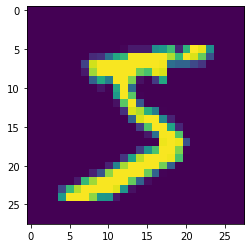

In [6]:
plt.imshow(X_train[0]);

### <a name='scale'>Scale the data</a>

In [7]:
X_train[0].shape

(28, 28)

#### [Why do we divide by 255?](https://stackoverflow.com/questions/20486700/why-do-we-always-divide-rgb-values-by-255#:~:text=It%20really%20comes%20down%20to,255%20since%200%20is%20included.)

Since 255 is the maximum value, dividing by 255 expresses a 0-1 representation. Each channel (Red, Green, and Blue are each channels) is 8 bits, so they are each limited to 256, in this case 255 since 0 is included.

In [8]:
X_train = X_train / 255 
X_test = X_test / 255

-------

# <a name=part1>PART I: Basic AutoEncoder</a>
+ There is super correct or wrong way as AutoEncoder are semi-supervised learning
+ we are going to build **Stacked AutoEncoder** meaning multiple stacked hidden layers that slowly reduce the dimensionality of the dataset.

# <a name=buildingautoencoder>Building AutoEncoder</a>

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.optimizers import SGD

In [10]:
28*28

784

In [11]:
784/2 #reduced by half

392.0

In [12]:
X_train[0].shape

(28, 28)

## <a name=buildingencoder>Building Encoder</a>

In [13]:
encoder = Sequential()

encoder.add(Flatten(input_shape=[28,28]))    # Flatten this from(28,28) to 784

encoder.add(Dense(400, activation='relu'))   # reduced to Half => 784 to 400
encoder.add(Dense(200, activation='relu'))   # reduced to Half => 400 to 200
encoder.add(Dense(100, activation='relu'))   # reduced to Half => 200 to 100
encoder.add(Dense(50, activation='relu'))   # reduced to Half => 100 to 50
encoder.add(Dense(25, activation='relu'))   # reduced to Half => 50 to 25   (reduced to 3% of original dimensions)

In [14]:
100 * 25/784

3.188775510204082

## <a name=buildingdecoder>Building Decoder</a>
+ Now we are basically reversing what encoder has done
+ when we decode, we need to skip the Central layer (which is the last layer of encoder; in our case 25 neurons one)

### We need to use sigmoid in second to last layer
+ we are using Binarycrossentropy loss at the end of our autoencoder, checking whether the output image (after going through all encoders) matched the original image.

### Why we use Binarycrossentropy for loss?
+ Autoencoder doesn't care how many types of distinct numbers are or classes.
+ All it cares it the image I am producing at the output going to match the image that is originally put as input.

In [15]:
decoder = Sequential()

decoder.add(Dense(50, input_shape=[25], activation='relu'))    # here we use input_shape as 25 which is the last layer of our encoder
decoder.add(Dense(100, activation='relu'))
decoder.add(Dense(200, activation='relu'))
decoder.add(Dense(400, activation='relu'))
decoder.add(Dense(28 *28, activation='sigmoid'))     # activation needs to be sigmoid because we are using binarycrossentropy loss

decoder.add(Reshape([28,28]))   # reshape back (28,28) image

## <a name=combining>Combining Encoder + Decoder as AutoEncoder</a>

In [16]:
autoencoder = Sequential([encoder, decoder])

In [17]:
autoencoder.compile(loss='binary_crossentropy',
                                   optimizer=SGD(lr=1.5), 
                                   metrics=['accuracy'])

# <a name=trainingautoencoder>Training AutoEncoder</a>
Take note that AutoEncoder is semi-supervised learning. It is not actually trying to predict the classification or anything.
All it doing is trying to learn the important features and reduce the dimensionality.

So when giving input and ouput for fitting is different from supervised learning ones.

In [18]:
X_train.shape

(60000, 28, 28)

In [19]:
autoencoder.fit(X_train, X_train,
                       epochs=5,
                       validation_data=(X_test, X_test))

Epoch 1/5
1875/1875 [==============================] - 32s 16ms/step - loss: 0.2971 - accuracy: 0.0700 - val_loss: 0.2133 - val_accuracy: 0.1304
Epoch 2/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2052 - accuracy: 0.1421 - val_loss: 0.1730 - val_accuracy: 0.1808
Epoch 3/5
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1683 - accuracy: 0.1885 - val_loss: 0.1533 - val_accuracy: 0.2063
Epoch 4/5
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1509 - accuracy: 0.2107 - val_loss: 0.1518 - val_accuracy: 0.2067
Epoch 5/5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.1435 - accuracy: 0.2197 - val_loss: 0.1344 - val_accuracy: 0.2230


# <a name=checkimage>Check how images look like after passing through AutoEncoder</a>

We will pass 10 images that AutoEncoder **DOES NOT TRAINED ON**. 

Let's see how autoencoder predicts(attempts to reconstruct after reducing the dimensionality) those images.

In [21]:
passed_images = autoencoder.predict(X_test[:10])

Original Image


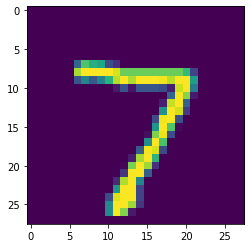

Attempted Reconstruction (after autoencoder)


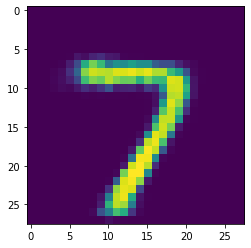

In [28]:
n = 0

print('Original Image')
plt.imshow(X_test[n])
plt.show();

print('Attempted Reconstruction (after autoencoder)')
plt.imshow(passed_images[n]);

------

# <a name=part2>PART II: AutoEncoders for Denoising Images</a>

# <a name=addingnoise>Demo for adding nosies</a>

+ There are many way to add noise into images. For the sake of convinence, we will use `GaussianNoise`
+ The larger value we choose for `std` parameter, the more noise will be added.

In [31]:
from tensorflow.keras.layers import GaussianNoise

In [33]:
sample = GaussianNoise(0.2) # the higher the std value, the nosier

In [34]:
noisey = sample(X_test[:10], training=True) # training on the first 10 images of Test dataset

Original Image


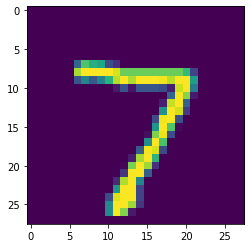

Noisey Version


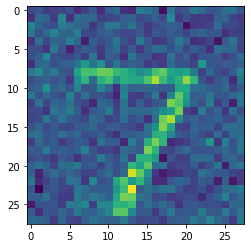

In [37]:
n = 0

print('Original Image')
plt.imshow(X_test[n])
plt.show();

print('Noisey Version')
plt.imshow(noisey[n]);

-----

# <a name=noiseremovalautoencoder>Building Noise Removal Autoencoder</a> 

## Encoder

In [38]:
import tensorflow as tf

In [39]:
tf.random.set_seed(101) #same as np.random.seed(101)

In [40]:
encoder = Sequential()

encoder.add(Flatten(input_shape = [28,28]))

# Add noise to images before going through autoencoder
encoder.add(GaussianNoise(0.2))

encoder.add(Dense(400, activation='relu'))
encoder.add(Dense(200, activation='relu'))
encoder.add(Dense(100, activation='relu'))
encoder.add(Dense(50, activation='relu'))
encoder.add(Dense(25, activation='relu'))

## Decoder

In [41]:
decoder = Sequential()

decoder.add(Dense(50, input_shape =[25], activation='relu'))
decoder.add(Dense(100, activation='relu'))
decoder.add(Dense(200, activation='relu'))
decoder.add(Dense(400, activation='relu'))
decoder.add(Dense(784, activation='sigmoid'))

decoder.add(Reshape([28,28]))

## Combine Encoder and Decoder as Noise Remover AutoEncoder

In [42]:
noise_remover = Sequential([encoder, decoder])

In [44]:
noise_remover.compile(loss='binary_crossentropy', 
                                     optimizer=SGD(lr=1.5),
                                     metrics=['accuracy'])

# <a name=trainnoiseremover>Train Noise Remover AutoEncoder</a> 

In [46]:
noise_remover.fit(X_train, X_train,
                             epochs=8,
                             validation_data=(X_test, X_test))

Epoch 1/8
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2930 - accuracy: 0.0698 - val_loss: 0.2211 - val_accuracy: 0.1141
Epoch 2/8
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2055 - accuracy: 0.1333 - val_loss: 0.1734 - val_accuracy: 0.1734
Epoch 3/8
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1680 - accuracy: 0.1875 - val_loss: 0.1540 - val_accuracy: 0.2076
Epoch 4/8
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1536 - accuracy: 0.2082 - val_loss: 0.1474 - val_accuracy: 0.2204
Epoch 5/8
1875/1875 [==============================] - 27s 15ms/step - loss: 0.1467 - accuracy: 0.2184 - val_loss: 0.1401 - val_accuracy: 0.2177
Epoch 6/8
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1399 - accuracy: 0.2258 - val_loss: 0.1309 - val_accuracy: 0.2349
Epoch 7/8
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1347 - accuracy: 0.2323 - val_loss: 0.1320 - val_ac

# <a name=noisyhandle>Check how Noisey Images are handled</a>

In [48]:
# create 10 noisy images
ten_noisey_images = sample(X_test[:10], training=True)

### Pass in the noisey images through Noise Remover

In [49]:
denoised = noise_remover(ten_noisey_images)

Original Image


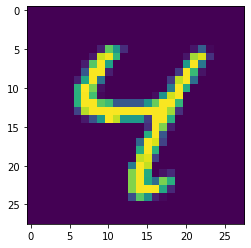

Noise Added Image


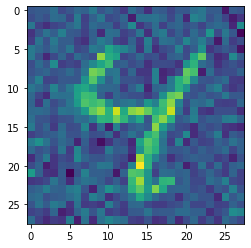

After Noise Removal from AutoEncoder


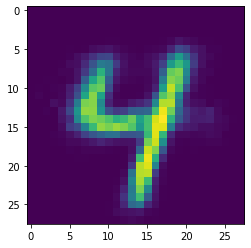

In [56]:
n = 6

print('Original Image')
plt.imshow(X_test[n])
plt.show()

print('Noise Added Image')
plt.imshow(ten_noisey_images[n])
plt.show()

print('After Noise Removal from AutoEncoder')
plt.imshow(denoised[n])
plt.show()